In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
#from skimage.transform import resize
from numpy.fft import fftn, fftshift

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split


/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

In [3]:
EPOCHS = 1000
NGPUS = torch.cuda.device_count()
BATCH_SIZE = max(NGPUS,1) * 32
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 1 Batch size: 32 Learning rate: 0.001


### Generate clean and noisy data from a sin()

Text(0.5, 1.0, 'Training data')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


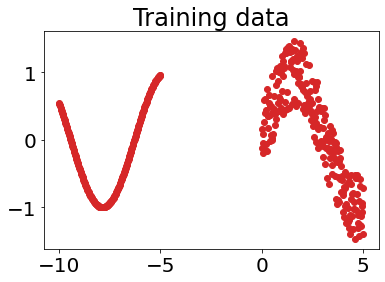

In [4]:
x_train = torch.cat([torch.linspace(-10,-5,250), torch.linspace(0,5,250)]) #Create tensor here and you're good
y_train  = torch.sin(x_train)
noise = np.concatenate([np.zeros(250),np.random.random(x_train[250:].shape)-0.5])
y_train += noise
plt.plot(x_train,y_train,'C3o')
plt.title("Training data")

Text(0.5, 1.0, 'Test data')

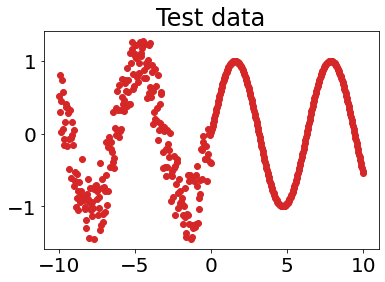

In [5]:
x_test = torch.linspace(-10,10,500) #Create tensor here and you're good
y_test  = torch.sin(x_test)
noise = np.concatenate([np.random.random(x_test[250:].shape)-0.5,np.zeros(250)])
y_test += noise
plt.plot(x_test,y_test,'C3o')
plt.title("Test data")

In [6]:
#Create a TensorDataset and batched loader
train_data = TensorDataset(x_train,y_train)
test_data = TensorDataset(x_test)
N_TRAIN = x_train.shape[0]
N_VALID = 100

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print("Train, valid and test", len(train_data2),len(valid_data),len(test_data))

trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Train, valid and test 400 100 500


In [7]:
class noisy_model(nn.Module):
    def __init__(self):
        super(noisy_model, self).__init__()
        self.D_in = 1 #Input dimension
        self.D_out = 1 #Output dimension
        self.H = [50,100,150] #Number of neurons in hidden layers

        self.fc = nn.Sequential(
            nn.Linear(self.D_in, self.H[0]), #Input 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.H[0], self.H[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.H[1], self.H[2]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.H[2],self.D_out)
        )
    def forward(self,x):
        return self.fc(x)

### Print model summary and move to GPU if available

In [8]:
model = noisy_model()
summary(model,(1,1),device="cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]             100
              ReLU-2                [-1, 1, 50]               0
           Dropout-3                [-1, 1, 50]               0
            Linear-4               [-1, 1, 100]           5,100
              ReLU-5               [-1, 1, 100]               0
           Dropout-6               [-1, 1, 100]               0
            Linear-7               [-1, 1, 150]          15,150
              ReLU-8               [-1, 1, 150]               0
           Dropout-9               [-1, 1, 150]               0
           Linear-10                 [-1, 1, 1]             151
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Tot

In [9]:
for x,y in trainloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.unsqueeze(-1))
    print("Trainloader", x.shape,y.shape,y_pred.shape)
    break

for x,y in validloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.unsqueeze(-1))
    print("Validloader", x.shape,y.shape,y_pred.shape)
    break

Trainloader torch.Size([32]) torch.Size([32]) torch.Size([32, 1])
Validloader torch.Size([32]) torch.Size([32]) torch.Size([32, 1])


In [10]:
#Optimization details
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [11]:
def train(trainloader, metrics):
    tot_loss = 0.0
    for i , (x, y) in enumerate(trainloader):
        x = x.to(device) #Move data to approp device
        y = y.to(device)

        y_pred = model(x.unsqueeze(-1)) #Forward pass

        loss = criterion (y_pred.squeeze(), y) #Compute loss
        tot_loss += loss.detach().item()

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i]) 


def validate(validloader, metrics):
    tot_loss = 0.0
    for j , (x, y) in enumerate(validloader):
        x = x.to(device) #Move data to approp device
        y = y.to(device)

        y_pred = model(x.unsqueeze(-1)) #Forward pass

        loss = criterion (y_pred.squeeze(), y) #Compute loss
        tot_loss += loss.detach().item()
        
    metrics['val_losses'].append([tot_loss/j])


In [12]:
metrics = {'losses':[],'val_losses':[]}#, 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))

Epoch: 0 | Train Loss: 0.62968 | Val Loss: 0.82173
Epoch: 1 | Train Loss: 0.57991 | Val Loss: 0.78573
Epoch: 2 | Train Loss: 0.55777 | Val Loss: 0.64187
Epoch: 3 | Train Loss: 0.49150 | Val Loss: 0.47109
Epoch: 4 | Train Loss: 0.50389 | Val Loss: 0.54046
Epoch: 5 | Train Loss: 0.50258 | Val Loss: 0.53975
Epoch: 6 | Train Loss: 0.47873 | Val Loss: 0.50970
Epoch: 7 | Train Loss: 0.48111 | Val Loss: 0.61796
Epoch: 8 | Train Loss: 0.46173 | Val Loss: 0.54822
Epoch: 9 | Train Loss: 0.47414 | Val Loss: 0.45900
Epoch: 10 | Train Loss: 0.44846 | Val Loss: 0.51724
Epoch: 11 | Train Loss: 0.46695 | Val Loss: 0.53360
Epoch: 12 | Train Loss: 0.44355 | Val Loss: 0.47538
Epoch: 13 | Train Loss: 0.46122 | Val Loss: 0.58456
Epoch: 14 | Train Loss: 0.46164 | Val Loss: 0.56933
Epoch: 15 | Train Loss: 0.46163 | Val Loss: 0.46373
Epoch: 16 | Train Loss: 0.43543 | Val Loss: 0.57334
Epoch: 17 | Train Loss: 0.44554 | Val Loss: 0.60108
Epoch: 18 | Train Loss: 0.46379 | Val Loss: 0.53318
Epoch: 19 | Train Loss

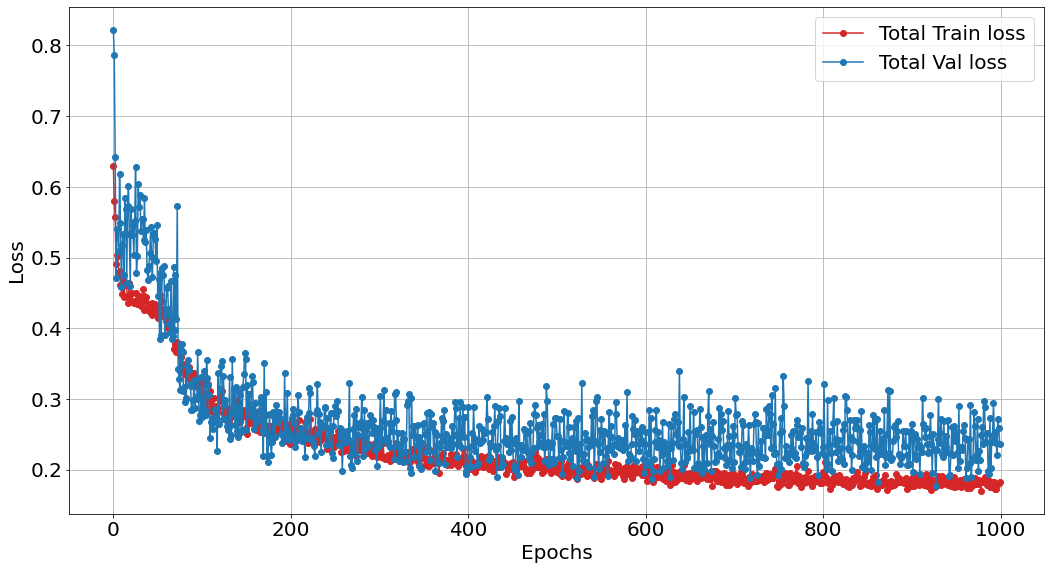

In [13]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()

plt.tight_layout()
plt.xlabel("Epochs")
plt.legend()

In [14]:
# Evaluate points with trained model
#model.eval()
def model_predict(model, loader):
    model.train()
    y_preds = []
    for x in loader:
        x = x[0].to(device)
        evals = model(x.unsqueeze(-1)).squeeze()
        for k in evals:
            y_preds.append(k.detach().to("cpu").numpy())
    y_preds = np.array(y_preds)
    return y_preds


In [15]:
T = 100 #How many samples to draw over test data?

100%|██████████| 100/100 [00:53<00:00,  1.89it/s]

(100, 500)
(500,)


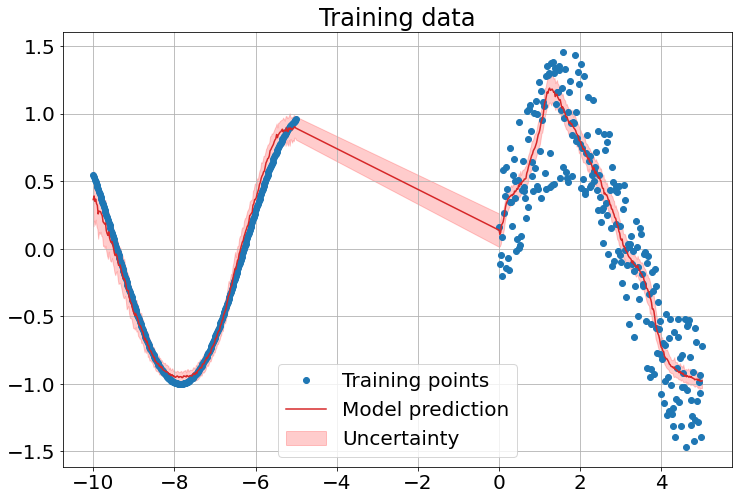

In [16]:
train_data = TensorDataset(x_train,y_train)
trainloader_full = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#Eval on training data
probs = []
for i in tqdm(range(T)):
    probs.append(model_predict(model, trainloader_full))

probs = np.array(probs)
print(probs.shape)

means = np.mean(probs, axis =0)
print(means.shape)

mean_pred = means #Take mean (over forward samples) of mean predictions
epistemic_std = np.std(probs, axis=0) #Take std over mean predictions

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(x_train,y_train,'C0o', label='Training points') #100 gone to validation
ax.plot(x_train, mean_pred, 'C3-', label='Model prediction')
ax.fill_between(x_train, mean_pred-epistemic_std, mean_pred+epistemic_std, 
                color='red', alpha=0.2, label="Uncertainty")
plt.title("Training data")
ax.grid()
plt.legend()

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]

(100, 500)
(500,)


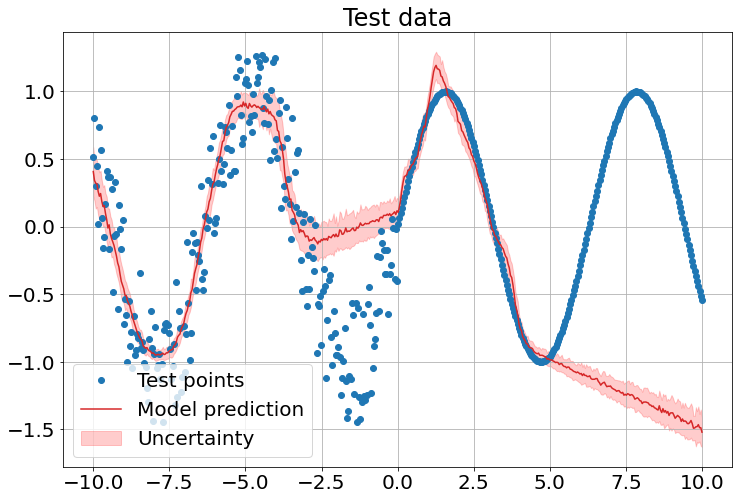

In [17]:
#Eval on test data
probs = []
for i in tqdm(range(T)):
    probs.append(model_predict(model, testloader))

probs = np.array(probs)
print(probs.shape)

means = np.mean(probs, axis =0)
print(means.shape)

mean_pred = means #Take mean (over forward samples) of mean predictions
epistemic_std = np.std(probs, axis=0) #Take std over mean predictions

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(x_test,y_test,'C0o', label="Test points")
ax.plot(x_test,mean_pred, 'C3-', label="Model prediction")
ax.fill_between(x_test,mean_pred-epistemic_std, mean_pred+epistemic_std, 
                color='red', alpha=0.2, label="Uncertainty")
plt.title("Test data")
ax.grid()
plt.legend()